Presentation by Andrew Kitterman and Yaning Liu.

In [5]:
from funcs import *
from other import *

# 1. The POD Technique
Citing (1), we can describe the algorithm that is the basis for the other algorithms we will be investigating as follows: <br>
Consider a set of solutions to a Partial Differential Equation (main application of this method) at times $t \in T$, where $T$ is our time domain. Our goal is to estimate the solution at a new time $t_{0}$. Then we can do that in the following way: <br>
1. Write the set of solutions as $U_{1},...,U_{n}$, where the index denotes the solution at the $n^{th}$ time value. Concatenate these into a vector $U = [U_{1},...,U_{n}]$. <br>
2. Compute the right singular vectors of $U$ either by using the SVD or by solving the eigenvector problem for the covariance matrix of $U$, $U^{T}U$. In practice SVD is the easiest method, and it allows for room to improve the computational time of our algorithm. <br>
3. Extract the right singular vectors from the SVD. <br>
4. These right singular vectors represent the row space of $U$. So, to estimate a solution at a new time $t_{0}$, we create a test case and solve the minimization problem $U_{t_{0}} = \sum_{i=1}^{m} \phi_{i}B_{i}$, where $m$ is the prescribed number of right singular vectors to use for the approximation, $\phi_{i}$ represents the $i^{th}$ right singular vector, and $B_{i}$ represents the coefficient of the $i^{th}$ singular vector. <br>
This works well, and it's a mature method. So, let us now turn our attention to one of the algorithms of interest: POD for multifidelity modeling, or PODMM.

# 2. PODMM
Citing (2), we describe the first algorithm of interest. However, there are some notable differences between the two algorithms. First, to do PODMM, we need a coarse resolution solution (done on only a few points), and a fine resolution solution (done on many points). You also need to come with one $g$ that is currently a coarse resolution solution (cheap to compute) at the time of interest. The algorithm produces an approximation to $f$ at the time of interest (f unknown, and expensive to compute). <br>
1. Write the set of coarse and fine resolution solutions respectively as $g = [g_{1},...,g_{n}], f = [f_{1},...,f_{n}]$, and stack them into a vector $W = \begin{equation}
\left[
  \begin{array}{cccc}
  f_{1} & ... & f_{n} \\
  g_{1} & ... & g_{n} \\
  \end{array}
\right]
\end{equation}$ <br>
2. Subtract the mean the solutions. So then $W_{f}$ recieves $W_{f} - \frac{1}{n}\sum_{i=1}^{n}f_{i}$, and $W_{g}$ recieves $W_{g} -  \frac{1}{n}\sum_{i=1}^{n}g_{i}$. <br>
3. Compute the SVD of $W$, extract the right singular vectors, then compute the projection onto the POD modes $\zeta_{i} = Wv_{i}$, where $v_{i}$ is the $i^{th}$ right singular vector. The point is that this projection captures the dominant modes of variability in the data matrix, so it's a good idea to use this for our approximation. <br>
4. Decompose $\zeta_{i}$ into $\zeta_{i} = \begin{equation}\left[\begin{array}{cccc}\zeta_{i}^{f}\\ \zeta_{i}^{g}\end{array}\right]\end{equation}$ <br>
5. Then we can take $g_{approx} = \overline{g} + \sum_{i=1}^{m} \gamma_{i}\zeta^{g}_{i}$. We will use these $\gamma_{i}$ that result from minimizing this sum to approximate $f$ as $f_{approx} = \overline{f} + \sum_{i=1}^{m} \gamma_{i}\zeta^{f}_{i}$. $m$ is the prescribed number of POD modes. <br>
6. The training step concludes by minimizing the two-norm of the difference between $g, g_{approx}$ and storing the $\gamma_{i}$ that result from this. <br>
7. For prediction, write $f = \overline{f} + \sum_{i=1}^{m}\gamma_{i}\zeta^{f}_{i}$. Note that solving for gamma this way is not the empirical minimizer of error, but we expect that if $f,g$ are "similar enough" that the approximation is good. And we see that this actually does happen in practice.

In [8]:
g_test = ADRSource(1,50,qs[30]*x*(10-x),omg[50],vs[92],k1s[135])[0]
f_test = ADRSource(1,2000,qs[30]*y*(10-y),omg[50],vs[92],k1s[135])[0]

In [9]:
fv,gv,fm,gm = POD_Train(fine_sol,coarse_sol,100)
f_appr = PODMM_Predict(g_test,fv,gv,fm,gm,100)
f_test = np.reshape(f_test,(-1,1))
np.linalg.norm(np.abs(f_appr-f_test)/np.abs(f_test))

5.854700792098884e-05

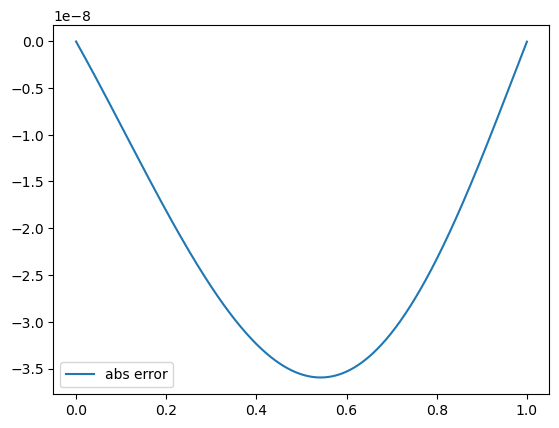

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
#Do this later
#f_test = np.reshape(f_test,(-1,1))
plt.plot(y,f_appr-f_test,label='abs error')
#plt.plot(y,f_test,label='test')
plt.legend()
plt.show()

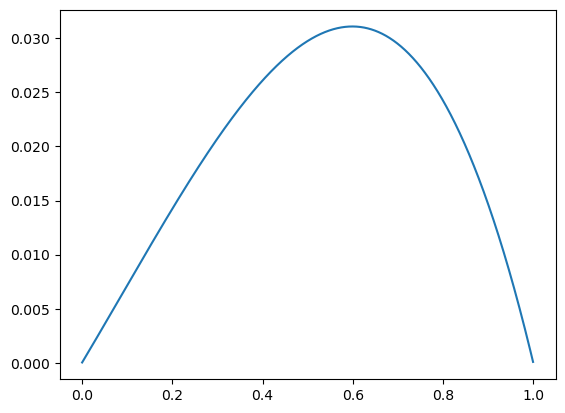

In [5]:
plt.plot(y,f_appr)

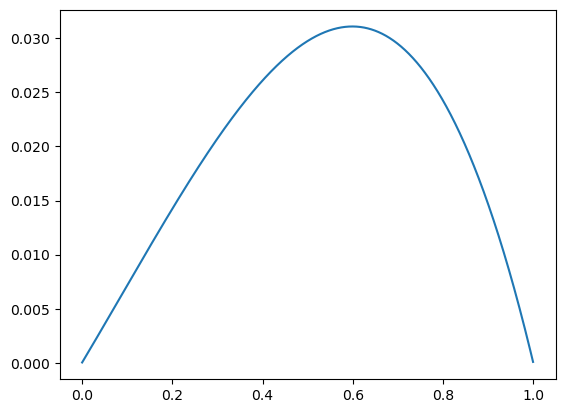

In [6]:
plt.plot(y,f_test)

# 3. Advancements in the PODMM Technique
PODMM is not as mature as POD - it is not as well studied, so there is room for improvement. One of the main ways we aim to improve the technique is by using a different covariance kernel. The standard POD technique is known to minimize the 2-norm of the error, but we abandoned that idea when we moved on to PODMM. The only point of interest is finding one such $\gamma$ such that the error is within our tolerance bound. The point is that if we measure error in the 2-norm, it seems like the only plan is to use the empirical minimizer which comes from the standard covariance matrix. However, now that we aren't interested in minimizing error that way, the use of other kernels is valid. What we are about to see is a toy example where a specific kernel is at least as good as the standard technique, but benefits from the built-in optimization of sklearn. <br>


In [7]:
f_kPOD,g_kPOD,fk_means,gk_means = PODM(fine_sol,coarse_sol,'sigmoid',None,30)
f_pred_2 = PODMM_Predict(g_test,f_kPOD,g_kPOD,fk_means,gk_means,30)
f_pred_2 = np.reshape(f_pred_2,(-1,1))

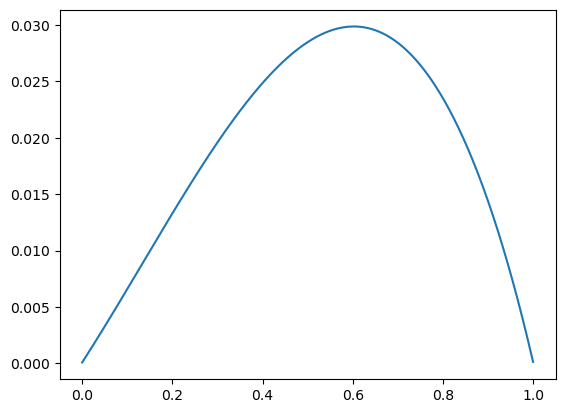

In [8]:
plt.plot(y,f_pred_2)

In [9]:
fv,gv,fm,gm = POD_Train(fine_sol,coarse_sol,30)
f_appr = PODMM_Predict(g_test,fv,gv,fm,gm,30)

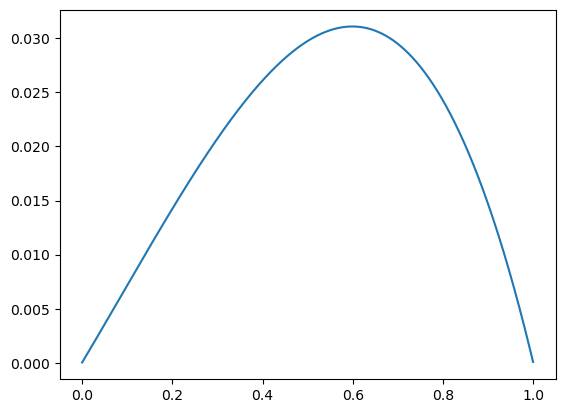

In [10]:
plt.plot(y,f_appr)

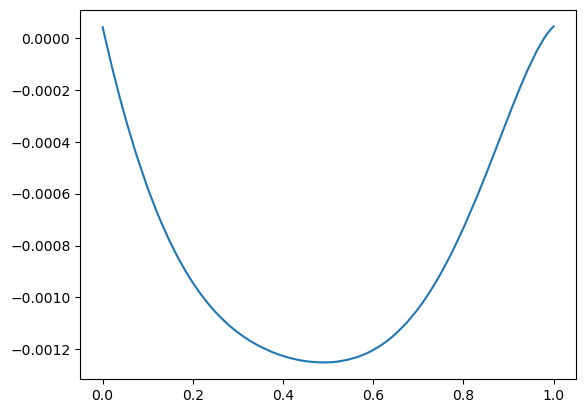

In [11]:
plt.plot(y,f_pred_2-f_test)

Our current numerical results indicate that kernel PCA may be better used when the number of POD bases is small. Or, when we don't have a lot of solution data with which to approximate our desired test solution.

# 4. Empirically minimizing error in the basic method
So, we discussed before that we avoid using the empirical minimizer in our work. We discuss in further detail why that is the case. First we establish what the empirical minimizer is. <br>
1. Suppose we can write $g= \phi_{1}B_{1} + ... + \phi_{n}B_{n}$. We can write any $g$ in the same way. Taking an inner product on both sides, we obtain <br>
2. $\langle g, \phi_{1} \rangle = B_{1}$. Repeating this process $n$ times yields $n$ coefficients<br>
These $B_{i}$ are the coefficients that minimize the error function $\|g-g_{e}\|_{2}^{2}$. <br>
However, this isn't very robust. So our strategy solves the robustness issue in the following way: <br>
1. Abandon the empirical minimizer <br>
2. Solve an optimization problem <br>
Any set of coefficients $\{B\}$ that results will be part of a "minimization cluster"(2), points that are very close to the resultant vector will also be a very good minimizer of error. This actually is better for us computationally than using the empirical minimizer. Coarse resolution solutions provide less information than the fine resolution; many of the coefficients determined in a training step could be 

# 5. POD for Data Reconstruction.
Citing (3), we can describe an algorithm for data reconstruction that uses the POD method in the following way: <br>
1. Consider a snapshot set $U$. <br>
2. Obtain right singular vectors of $U$. <br>
3. $g$ is another solution vector with some elements missing and a mask vector $n$. <br>
4. Write $g = \sum_{i}\phi_{i}B_{i}$. However, since some elements of $g$ are missing, we can't use the strategy in 4. We need to define the gappy inner product as follows:
$\langle u,v \rangle_{n} = \langle (u,n), (v,n) \rangle$, where $(\cdot,\cdot)$ is pointwise multiplication. <br>
5. $\langle g, \phi_{i}\rangle_{n} = \langle B_{i} \sum_{i}\phi_{i}, \phi_{j}\rangle_{n}$. This yields a system of equations<br>
$Mb = f, M_{i,j} = \langle \phi_{i},\phi_{j} \rangle_{n}, f_{i} = \langle g, \phi_{i} \rangle_{n}$ and of course b is our target vector.
6. We then obtain $\hat{g}$, the repaired data vector, using (3). <br>
7. Replace $g_{i}$ with $\hat{g}_{i}$ if $n_{i} = 0$
We will now see an example of POD for Data Reconstruction.

In [12]:
test = coarse_sol[:,1]
n = np.ones((len(test)))
for i in range(len(test)):
    x = np.random.uniform(0,1)
    if(x<.11):
        test[i] = 0
        n[i] = 0
n,test

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]),
 array([0.00163761, 0.00329103, 0.00495562, 0.00662672, 0.00829965,
        0.00996971, 0.01163216, 0.01328224, 0.01491518, 0.        ,
        0.01811033, 0.01966284, 0.02117878, 0.02265324, 0.02408127,
        0.02545787, 0.02677804, 0.02803672, 0.02922886, 0.03034933,
        0.031393  , 0.03235469, 0.        , 0.03401128, 0.03469567,
        0.03527705, 0.03575006, 0.        , 0.03634945, 0.03646494,
        0.03645032, 0.03630004, 0.03600853, 0.03557017, 0.        ,
        0.03423025, 0.03331724, 0.        , 0.03097623, 0.02953653,
        0.02790948, 0.02608913, 0.02406947, 0.02184444, 0.01940794,
        0.01675381, 0.01387586, 0.        , 0.00742343, 0.00383629]))

In [13]:
g,g_estim = reconstruct_data_3(coarse_sol.T,test,n)

4.992230468394189e-31


In [14]:
np.linalg.norm(np.abs(test-g_estim)/np.abs(test),2)

6.139942349306287e-14

# 6. A new approach to MM with missing data using POD
It is known that POD bases can be used for MM with missing data (4), but we present a new method for doing this. suppose f,g have missing values. Then <br>
1. reconstruct g <br>
2. POD_Train(F,G) <br>
3. POD_Predict(g,zeta_f,zeta_g) <br>
4. f[i] = $\hat{f_{i}}$ if $mask_f[i] = 0$

In [15]:
dang = Bui_MM(F_soln,G_soln,test_g,test_f,g_in,f_in,mask_g,mask_f)
(np.linalg.norm(np.abs(dang-test_f)/np.abs(test_f)))

C:\Users\Budde\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


3.423641402702122e-32


3.830462185319695e-05

# 7. Further Research
1. Determining under which circumstances which kernels have the best performance in the PODMM method. <br>
2. Implement manifold learning for dimension reduction in the PODMM method. <br>
3. The data reconstruction method can be used to determine target coordinate values (PDE has been solved but sensor data is missing/incomplete for the points it was solved at), among other targets of interest. For example, if we have one set of snapshots $U$, and other incomplete set of snapshots $G$, we can use this method to estimate the POD bases of $G$ for data reconstruction on $G$, as long as $U$ and $G$ have some kind of similarity (we expect $G$ to be 20% larger, we know $G$ is similar on the boundaries but has data values ranging between -10% and 10% on non-boundary points, etc). Note that in this case we cannot REALLY use $U$ to estimate $G$ in the standard way, because perturbing a matrix can change the SVD/POD Bases by quite a bit relative to the size of the perturbation. <br>
4. I mentioned earlier that we want to, in general, use a large number of POD bases. One extension of the PODMM method is using snapshot sets in correlated variables as part of the data matrix W. This allows for using more POD bases (the variance gets explained across more eigenfunctions), but can create large data matrices that make the SVD computation hard. We aim to incorporate randomized SVD to handle this. <br>
5. It may be the case that a user wants to estimate a solution at more points than we have available. So instead of the data-driven approach we have now, we perform the PODMM method but instead of going from 50-2000, and the user wants 3000, we go 50-3000 by interpolating the solution at additional points using a physics-informed model to handle the lack of data. Then we perform PODMM on the interpolated data. <br>
6. Determining a computationally efficient way to effectively use the empirical minimizer. The only thing holding us back from using this (which does not necessarily hold others back - each reduced order model that is based on POD has it's own way of determining which set of coefficients to use) is the runtime. It's critical that we use $W\cdot V$ when determining the coefficients to capture the similarity in the way variance is distributed between the two solutions, 

# 8. References. <br>
1. SIROVICH, LAWRENCE. “TURBULENCE AND THE DYNAMICS OF COHERENT STRUCTURES PART I: COHERENT STRUCTURES.” Quarterly of Applied Mathematics, vol. 45, no. 3, 1987, pp. 561–71. JSTOR, http://www.jstor.org/stable/43637457. Accessed 9 Mar. 2024.<br>
2. Pau, G. S. H., C. Shen, W. J. Riley, and Y. Liu (2016), Accurate and efficient prediction of fine-resolution hydrologic and carbon dynamic simulations from coarse-resolution models, Water Resour. Res., 52, 791–812, doi:10.1002/2015WR017782.<br>
3. Bui-Thanh, Tan & Damodaran, Murali & Willcox, Karen. (2004). Aerodynamic Data Reconstruction and Inverse Design Using Proper Orthogonal Decomposition. Aiaa Journal - AIAA J. 42. 1505-1516. 10.2514/1.2159. 
4. Perron, Christian & Rajaram, Dushhyanth & Mavris, Dimitri. (2021). Multi-fidelity non-intrusive reduced-order modelling based on manifold alignment. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences. 477. 20210495. 10.1098/rspa.2021.0495. 